## Part 2 of: "learning the Q-values with a neural network" ##

In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In the previous "tutorial" we show that it's possible to learn the uderlying function that relates different arms of a non-linear bandit problem.

\\ 

In this notebook we will do the same, but now we add some "context" to each arm; and still there's a nonlinear function for the mean reward relating differnt arms 

In [2]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


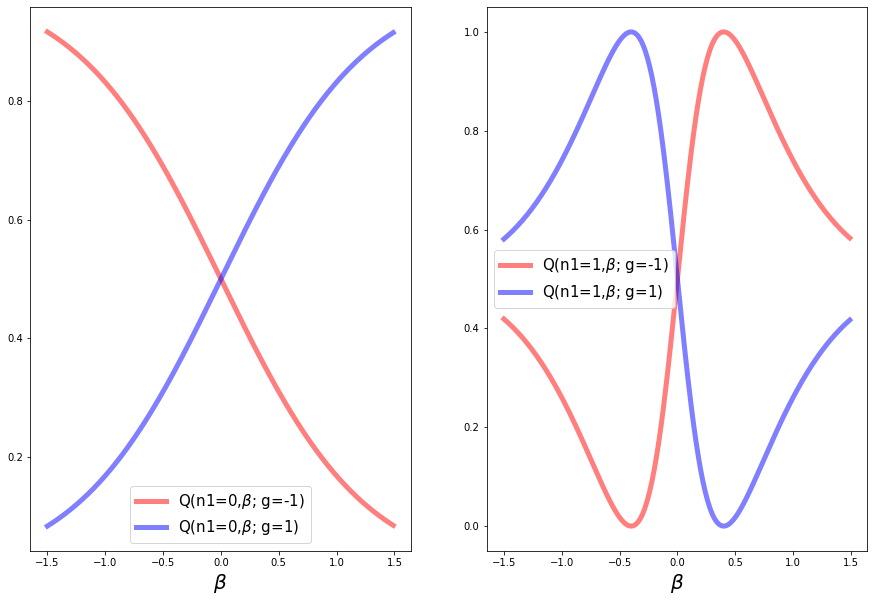

In [3]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas,[qval(b, 0, -1) for b in betas],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas,[qval(b, 0, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas,[qval(b, 1, -1) for b in betas],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas,[qval(b, 1, 1) for b in betas],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


Now let's create a dataset; the idea is to sample a reward many times for a given beta.

In [78]:
def createdataset_l2(number_rews_per_beta_per_outcome_per_guess=10**2,number_of_betas = 10):
    #we call it l2 so it does not interfer with the fist tutoral..
    dataset = []
    labels=[]
    global betas_train
    global number_of_samples
    number_of_samples = number_rews_per_beta_per_outcome_per_guess
    betas_train = np.linspace(-1.5,1.5,number_of_betas)
    for i in range(len(betas_train)):
        beta = betas_train[i]
        for outcome in [0.,1.]:
            for guess in [-1.,1.]:

                for k in range(number_rews_per_beta_per_outcome_per_guess):
                    mean_bernoulli = qval(beta, outcome, guess)
                    reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                    dataset.append([beta, outcome, guess, reward])
    return np.array(dataset)

We can plot the data obtained, it's noisy!

Obviously, the more you sample the less noisy the average is!

In [7]:
data = createdataset_l2(10**3)
data = np.split(data, len(betas_train))

In [8]:
mean_values = {}
for index_beta in range(len(betas_train)):
    mean_values[str(index_beta)] = {}

for index_beta, beta in enumerate(betas_train):
    sp = np.split(data[index_beta],4)
    for index_ng in range(4):
        mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

## Let's see the data! (now it's a bit more involved to plot it, as for a given beta you have some index of n and g ##

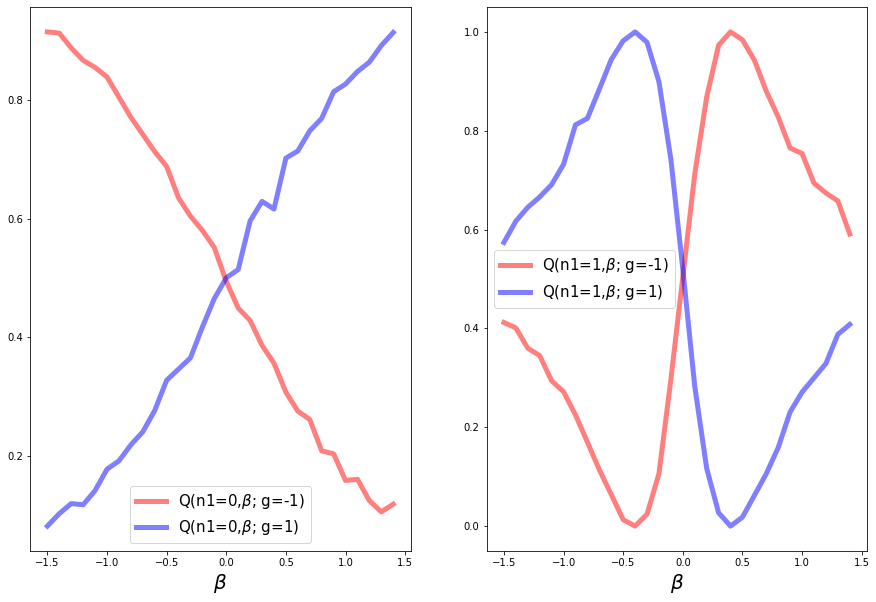

In [9]:
plt.figure(figsize=(15,10))
ax1 =  plt.subplot2grid((1,2),(0,0))
ax2 =  plt.subplot2grid((1,2),(0,1))

betas = np.arange(-1.5,1.5,.01)
ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],alpha=0.5,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],alpha=0.5,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],alpha=0.5,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\beta$', size=20)
    ax.legend(prop={"size":15})


## Now we want to train a network, defined below as Net1(), to learn this function over stochastic rewards, as we did in the case of a single $\beta$. The arquitecture we'll use is, as income, $(\beta, n, g)$ and as output $\hat{Q}(\beta, b ; g)$. ##

### Notice the difference in the input_shape=(3,) for self.l1 ##

In [10]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l2(feat))
        feat = tf.nn.dropout(feat, rate=0.01)
        feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


## How do we feed the network with this food ? ##

In [21]:
data[0]

array([[-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       [-1.5,  0. , -1. ,  1. ],
       ...,
       [-1.5,  1. ,  1. ,  0. ],
       [-1.5,  1. ,  1. ,  1. ],
       [-1.5,  1. ,  1. ,  0. ]])

In [26]:
food =data[0][:,[0,1,2]]

In [31]:
print(food[:5])

[[-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]
 [-1.5  0.  -1. ]]


In [32]:
net= Net()
net(food)[:5]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.50630818],
       [0.50633824],
       [0.50633824],
       [0.50633824],
       [0.50634624]])>

** comment **: the difference in the values is due to the drop-out rate!

### Now that we are convinced we can learn the mean value of a (parametrized) distibution from noisy data, let's see how this get affected if we shuffle the data points (each batch is comoposed from different values of displacements).###

\\



### Notice also that the results are even **better**!###

In [36]:
dd1 = createdataset_l2(10**2)

In [39]:
np.random.shuffle(dd1)

In [46]:
number_splits = 5
dd1 = np.split(dd1,  number_splits + len(dd1)%number_splits)

In [47]:
net = Net()

In [49]:
preds = net(dd1[0][:,[0,1,2]])

In [50]:
labs = dd1[0][:,3]

In [52]:
tf.keras.losses.MSE(labs,preds)

<tf.Tensor: shape=(2400,), dtype=float64, numpy=
array([0.25047604, 0.25047782, 0.25047793, ..., 0.25047454, 0.2504667 ,
       0.25045727])>

In [54]:
net(foo)

<tf.Tensor: shape=(7, 1), dtype=float64, numpy=
array([[0.51288368],
       [0.51283691],
       [0.51277305],
       [0.51271808],
       [0.5125874 ],
       [0.51247577],
       [0.51239643]])>

In [100]:
def learning_problem(rews_per_beta, epochs=30, batch_size=100, number_of_betas=10):
    start = datetime.now()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    global dataset, net
    dataset = createdataset_l2(rews_per_beta, number_of_betas=number_of_betas)
    dataset_copy = dataset.copy()
    np.random.shuffle(dataset)
    
    number_splits = len(dataset/batch_size)
    dataset = np.split(dataset, number_splits + len(dataset)%number_splits) #spliting the dataset!
    net = Net()
    
    
    histo_preds = {} #here i save the predictions

    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()

        for batch in tqdm(dataset):
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(batch[:,[0,1,2]]) #make predictions in batch
                rews = batch[:,3]
                loss = tf.keras.losses.MSE(rews,preds)
                loss = tf.reduce_mean(loss)

                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
            epoch_loss_avg(loss)
        if (epoch % int(epochs/5) == 0)|(epoch==length_training-1):
            print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))

            histo_preds[str(epoch)] ={} 
            histo_preds[str(epoch)]["epoch_number"] = epoch
            histo_preds[str(epoch)]["values"] = {}

            index=0
            for n1 in [0.,1.]:
                for guess in [-1.,1.]:
                    foo =np.array([[b,n1,guess] for b in betas_train]) #betas_train defined as global in create_dataset_l2()
                    histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                    index+=1
    
    
    dataavg = np.split(dataset_copy, len(betas_train))

    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}

    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])

    print("Tardé: ", datetime.now()-start)
    return histo_preds, mean_values
    
    
#in this case the length is 500*4*30, 4 'cause the n1 and guess, 30 'cause the len(betas_train)

In [ ]:
histo_preds, mean_values = learning_problem(10,epochs=10, batch_size=1000,number_of_betas=10) 


## As the training takes more time, let us define a function to plot the results.. ##

In [96]:
def plot_results(histo_preds, mean_values, title=None):
    plt.figure(figsize=(15,15))
    ax1 =  plt.subplot2grid((1,2),(0,0))
    ax2 =  plt.subplot2grid((1,2),(0,1))

    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

        
    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

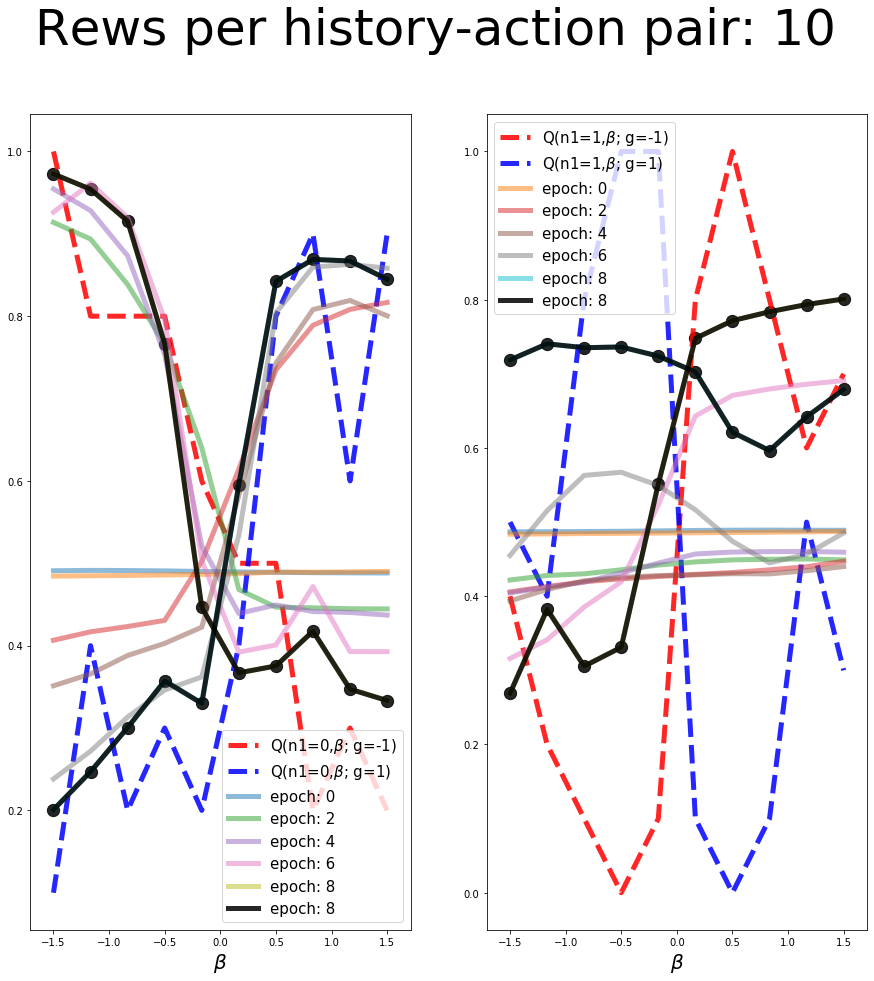

In [97]:
plot_results(histo_preds,mean_values, title="Rews per history-action pair: 10")

## Ok, now let's take a bit more of data ##

In [98]:
histo_preds1, mean_values1 = learning_problem(1000,epochs=10, batch_size=1000,number_of_betas=10) 
plot_results(histo_preds1,mean_values1, title="Rews per history-action pair: 10^3")

Epoch 000: Loss: 0.171
Epoch 002: Loss: 0.164


KeyboardInterrupt: 